In [24]:
from google.colab import drive

drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
# !ls '/content/gdrive/My Drive/data_set'

In [55]:
import pandas as pd
import librosa
import os
import numpy as np

In [27]:
PATH = '/content/gdrive/My Drive/data_set'

In [28]:
df = pd.read_excel(PATH+'/Voice_Data_Description.xlsx')
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,No.,ID No.,No. of Files,Lenght
1,1,ID001,4,10.47
2,2,ID002,5,7.07
3,3,ID003,5,8.05
4,4,ID004,4,9.39


In [29]:
df.columns = df.iloc[0]
df = df.drop([0])

In [30]:
df.head()

,No.,ID No.,No. of Files,Lenght
1,1,ID001,4,10.47
2,2,ID002,5,7.07
3,3,ID003,5,8.05
4,4,ID004,4,9.39
5,5,ID005,3,4.4


In [31]:
filename = PATH+'/ID00101.mp3'
X, sample_rate = librosa.load(filename)
#def get_data(file_path):
  

SyntaxError: ignored

In [57]:
data = {'speaker':[],'file':[]}
for index, row in df.iterrows():
  
  for i in range(row['No. of Files']):
    data['speaker'].append(int(row['ID No.'][2:5]))
    x = str(i+1) if len(str(i+1))==2 else '0'+str(i+1)
    data['file'].append(row['ID No.'] + x+'.mp3')
data = pd.DataFrame(data=data)

In [58]:
data.head()

,speaker,file
0,1,ID00101.mp3
1,1,ID00102.mp3
2,1,ID00103.mp3
3,1,ID00104.mp3
4,2,ID00201.mp3


In [59]:
def extract_features(filename):
      X, sample_rate = librosa.load(filename, res_type='kaiser_fast')
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
      stft = np.abs(librosa.stft(X))
      chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
      mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
      contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
      tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sample_rate).T,axis=0)
      return mfccs, chroma, mel, contrast, tonnetz



In [71]:
#s = extract_features(PATH+'/ID00101.mp3')
train_features = []

In [72]:
for index,row in data.iterrows():
  train_features.append(extract_features(PATH+'/'+row['file']))

KeyboardInterrupt: ignored

     speaker         file
0          1  ID00101.mp3
1          1  ID00102.mp3
2          1  ID00103.mp3
3          1  ID00104.mp3
4          2  ID00201.mp3
..       ...          ...
293       85  ID08503.mp3
294       86  ID08601.mp3
295       86  ID08602.mp3
296       86  ID08603.mp3
297       86  ID08604.mp3

[298 rows x 2 columns]


In [133]:
features_train = []
for i in range(0, len(train_features)):
    features_train.append(np.concatenate((
        train_features[i][0],
        train_features[i][1], 
        train_features[i][2], 
        train_features[i][3],
        train_features[i][4]), axis=0))


In [134]:
X_train = np.array(features_train)
y_train = np.array(data['speaker'])


In [135]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

In [136]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))

(298, 86)


In [138]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [148]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
model = Sequential()
model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(86, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [149]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100,validation_data=(X_val, y_val))

Epoch 1/100
13/13 [==============================] - 6s 58ms/step - loss: 4.6027 - accuracy: 0.0179 - val_loss: 4.1946 - val_accuracy: 0.1212
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 4.0806 - accuracy: 0.1367 - val_loss: 3.9191 - val_accuracy: 0.2626
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 3.6064 - accuracy: 0.1975 - val_loss: 3.6268 - val_accuracy: 0.3333
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 3.2266 - accuracy: 0.3296 - val_loss: 3.3672 - val_accuracy: 0.4444
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 2.8978 - accuracy: 0.3812 - val_loss: 3.1144 - val_accuracy: 0.5152
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 2.4561 - accuracy: 0.4498 - val_loss: 2.9327 - val_accuracy: 0.5354
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 2.4416 - accuracy: 0.3857 - val_loss: 2.7267 - val_accuracy: 0.5657
Epoch 8/100


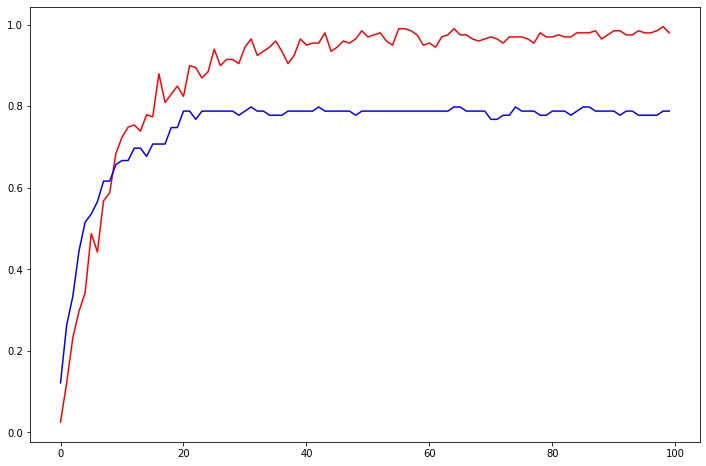

In [153]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')


(199, 193)


In [162]:
model.save('/content/gdrive/My Drive/model')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/model/assets


(99, 86)


gdrive	sample_data
